# Model training

This script trains a neural network based on a pretrained ResNet18 neural net on the training data and outputs the results in the form of learning curves. 

In [1]:
# Imports
import cv2
import math
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import albumentations as A
from torchvision import models
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from albumentations.pytorch import ToTensorV2

c:\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check if there is a graphical card (CUDA) available on the PC
device = torch.device("cuda:" + str(torch.cuda.current_device()) if torch.cuda.is_available() else "cpu")

In [3]:
# Set training parameters
epochs = 100 # Number of times that the model sees the whole dataset
learning_rate = 0.01 # Step size of the weight adjustment to reduce the error of the model
batch_size = 16 # Number of samples processed before the model is updated
augmentation = 0 # Boolean to set the usage of data augmentation on or off

The class below defines the dataset class. This class defines how the images and labels of each sample are processed before sent to the neural network. Before doing this, the image is read and processed, as well as the labels. By default, the image is resized, normalized, and converted to a tensor to be read by the neural network. When data augmentation is activated for the training, also other transformations are applied to the image. It is important that also the labels (cutting line) undergoes the same transformation as the image does. Finally, the transformed image and label are send to the neural network. 

In [4]:
# This class impements the Dataset
class Dataset(Dataset):

	def __init__(self, paths, transform=False):
		self.paths = paths # All file paths to the images
		self.transform = transform # Boolean to set the usage of data augmentation on or off

	def __len__(self):
		return len(self.paths)

	def __getitem__(self, idx):

		# Retrieve image file path
		img_path = self.paths[idx]

		# Read image and convert to RGB space
		image = cv2.imread(img_path) 
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

		# Get label [x1, y1, x2, y2]
		key = img_path.split('\\')[-1].split('.')[0]
		label_file = open("../data/labels/" + key + ".txt", "r")
		labeldata = label_file.read().split(" ")

		# Get keypoints [(x1, y1), (x2, y2)]
		keypoints = [(float(labeldata[4]), float(labeldata[5])), (float(labeldata[6]), float(labeldata[7]))]

		# Define augmentation pipeline
		if self.transform:
			transform = A.Compose([
				A.AdvancedBlur(),
				A.RandomGravel(),
				A.ISONoise(),
				A.RandomRotate90(p=0.5),
				A.HorizontalFlip(p=0.2),
				A.RandomBrightnessContrast(p=0.5),
				A.Resize(224, 224),
				A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
				ToTensorV2(),
			], keypoint_params=A.KeypointParams(format='xy', remove_invisible=True))
		else:
			transform = A.Compose([
				A.Resize(224, 224),
				A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
				ToTensorV2(),
			], keypoint_params=A.KeypointParams(format='xy', remove_invisible=True))
		
		# Transform image and keypoints
		transformed = transform(image=image, keypoints=keypoints)
		transformed_image = transformed['image']
		transformed_keypoints = transformed['keypoints']

		# Get target [x1, y1, x2, y2]
		target = np.array([transformed_keypoints[0][0], transformed_keypoints[0][1], transformed_keypoints[1][0], transformed_keypoints[1][1]])

		return transformed_image, target


In the next step, the data is read from the database and assigned to the dataset class. We will apply data augmentation to the training set but not on the validation set as these images should reflect the real situation properly. 

In [5]:
# Load csv files containing the image file paths
df_train = pd.read_pickle('../data/train_data.csv')
df_valid = pd.read_pickle('../data/valid_data.csv')

# Create datasets using the dataset class that applies image transforms if the transform parameter is set to True
train_ds = Dataset(df_train['path_names'], transform=augmentation)
valid_ds = Dataset(df_valid['path_names'], transform=False) 

Next, some dataloaders are defined for the train and validation set. These are able to load batches of data with a predefined size and send it to the network. 

In [6]:
# Create data loaders that extract batches from the dataset with a certain batch size
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
dataloaders = {'train': train_dl, 'valid': valid_dl}

Below, two cost functions are defined. A line can be represented by a point and an angle. The first loss function makes sure that one of the two predicted points lies as close as possible to the center of the two points defined by the line label. This to eliminate possible negative effects that result from the fact that the points have no fixed order. Sometimes the first of the two points in the label can represent the point at the right side of the chicory, and sometimes it can represent the left side. The second loss function makes sure that the predicted line lies collinear with the ground truth line. It does this by computing the cosine similarity and taking the inverse cosine of the result. This value is set in degrees. 

In [8]:
# Computes the Euclidean distance between the first predicted point and the center of the ground truth points
def loss_rmse_fun(pred, y):

	# Only get first xy point of prediction
	xy1_pred = torch.stack((pred[:,0], pred[:,1]), 1) 

	# Get center of two ground truth points
	y_centerx = (y[:,0] + y[:,2])/2
	y_centery = (y[:,1] + y[:,3])/2
	y_center = torch.stack((y_centerx, y_centery), 1)

	# Compute sum of Euclidean distances between first predicted point and center point
	loss = torch.sum(torch.sqrt(torch.sum((xy1_pred - y_center)**2, 1)))

	return loss

In [7]:
# Computes the error angle between the predicted and ground truth lines in degrees
def loss_cos_fun(pred, y):

	# Get x and y differences between predicted points
	delta_x_pred = pred[:,2]-pred[:,0]
	delta_y_pred = pred[:,3]-pred[:,1]

	# Get x and y differences between ground truth points
	delta_x_y = y[:,2]-y[:,0]
	delta_y_y = y[:,3]-y[:,1]

	# Stack both into new tensors
	a = torch.stack((delta_x_pred, delta_y_pred), 1)
	b = torch.stack((delta_x_y, delta_y_y), 1)

	# Compute the sum of anle differences in degrees
	loss = torch.sum(torch.acos(F.cosine_similarity(a, b, dim=1)) * 180 / math.pi)

	return loss

The function below is the main training function. It loops over the predefined number of epochs and for every epoch, trains on the whole dataset in batches with a predefined size. For every batch, the summed loss over all samples in the batch is computed. And the model is updated according to this loss. After the whole dataset passed, the average loss over all datasamples is computed to obtain the training loss. In a second pass, the model validates on the validation set and outputs a validation loss. Both are saved in an array to be visualized as learning curves later on.  

In [9]:
# This function implements the training and validation of the neural network
def train_model(model, optimizer, dataloaders, device, epochs):

	# Learning curves
	results = {"training_loss": [], "validation_loss": []}

	# Loop over epochs
	best_model = model
	best_loss = float('inf')
	for epoch in range(epochs):

		# Debug
		print(f'Epoch {epoch+1}/{epochs}')

		# Do a train and validation phase for each epoch
		for phase in ['train', 'valid']:

			# Set state of model corresponding to phase
			if phase == 'train':
				model.train()  # Set model to training mode
			else:
				model.eval()   # Set model to evaluate mode

			# Reset loss over all batches and number of samples 
			running_loss = 0.0
			num_samples = 0

			# Iterate over batches of inputs
			for x, y in dataloaders[phase]:

				# Inputs shape
				batch_size, *_ = x.shape

				# Convert input and outputs to CUDA
				x = x.to(device)
				y = y.to(device)

				# Predict line
				pred = model(x)

				# Compute total loss over batch
				loss_rmse_values = loss_rmse_fun(pred, y)
				loss_cos_values = loss_cos_fun(pred, y)
				loss = loss_rmse_values + loss_cos_values

				# Debug
				#debug(x, pred, y)

				# Sum losses of all batches
				running_loss += loss.item()

				# Calculate total samples
				num_samples += batch_size

				# When training
				if phase == 'train':
					optimizer.zero_grad() # Clear out gradients
					loss.backward() # Do backpropagation
					optimizer.step() # Step the optimizer

			# Compute total loss over the whole dataset (sum of loss of all samples divided by total number of samples)
			dataset_loss = running_loss/num_samples

			# Save results
			if phase == 'train':
				results['training_loss'].append(dataset_loss)
				print("train_loss %.3f" % (dataset_loss))
			elif phase == 'valid':
				results['validation_loss'].append(dataset_loss)
				print("val_loss %.3f" % (dataset_loss))

			# Save model
			if phase == 'valid' and dataset_loss < best_loss:
				best_model = model
				best_loss = dataset_loss

		# Debug
		print('-' * 10)

	return best_loss, best_model, results

The code below initiates the pretrained Resnet18 model and replaces the final fully connected layer (model.fc) with an untrained fully connected layer with four outputs ([x1, y1, x2, y2]). Also the model optimizer is defined. Finally, the above function is called to start training the network. 

In [10]:
# Load a pretrained ResNet18 model
model = models.resnet18(pretrained=True)

# Get the number of features of the last fully connected layer
total_features = model.fc.in_features

# Replace this final layer with a fully connected layer that outputs four neurons [x1, y1, x2, y2]
model.fc = nn.Sequential(nn.Linear(total_features, 4))

# Link model to device
model.to(device)

# Set optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train model
loss, model, results = train_model(model, optimizer, dataloaders, device, epochs=epochs)

Epoch 1/10
train_loss 229.672
val_loss 31291.067
----------
Epoch 2/10
train_loss 213.111
val_loss 969.971
----------
Epoch 3/10
train_loss 204.358
val_loss 274.251
----------
Epoch 4/10
train_loss 194.382
val_loss 157.309
----------
Epoch 5/10
train_loss 184.261
val_loss 186.310
----------
Epoch 6/10
train_loss 174.716
val_loss 178.251
----------
Epoch 7/10
train_loss 172.976
val_loss 136.554
----------
Epoch 8/10
train_loss 157.895
val_loss 134.532
----------
Epoch 9/10
train_loss 143.140
val_loss 141.540
----------
Epoch 10/10
train_loss 126.311
val_loss 95.532
----------


After training the network, the model is saved locally for later validation. 

In [11]:
# Model name
model_name = "model_" + str(learning_rate) + "-" + str(batch_size) + '-' + str(augmentation) + '-' + str(epochs)

# Save model
torch.save(model, '../models/' + model_name + '.pt')

The learning curves (training and validation losses is function of the number of epochs) are visualized.

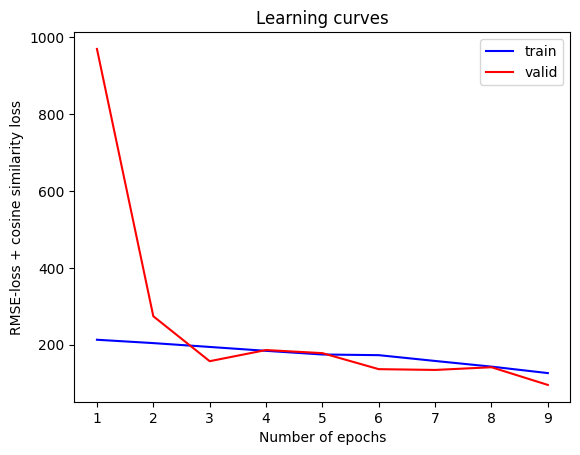

In [12]:
# Plot learning curves
fig = plt.figure(1)
mask = [i for i in range(len(results['validation_loss'])) if results['validation_loss'][i] < 1000]
results['training_loss'] = [results['training_loss'][i] for i in mask]
results['validation_loss'] = [results['validation_loss'][i] for i in mask]
plt.plot(range(1, len(mask)+1), results['training_loss'], 'b-', markersize=1, label='train')
plt.plot(range(1, len(mask)+1), results['validation_loss'], 'r-', markersize=1, label='valid')
plt.title('Learning curves')
plt.xlabel('Number of epochs')
plt.ylabel('RMSE-loss + cosine similarity loss')
plt.legend()